In [1]:
# lib imports
import torch
import json
from PIL import Image
from transformers import (
    AutoModelForImageTextToText, 
    AutoProcessor,
    AutoModelForCausalLM,
    Qwen2_5_VLForConditionalGeneration
)
from rich import print
from PIL import Image
from outlines import models, generate
from outlines.generate.api import GenerationParameters, SamplingParameters
from random import sample
from scipy.special import softmax
from IPython.display import display
from os.path import join
from peft import LoraConfig, PeftConfig, PeftModel

# this makes it to where you import other scripts from the repo using {subdir}.{fpath}    
# for notebooks sys.path[0] is the parent dir
import sys                  
from pathlib import Path
project_dir = str(Path(sys.path[0]).parent.parent.absolute())    
sys.path.append(project_dir) 

# task utils

# project utils
from utils.consts import scratch_tmp_fdir
from utils.shuffle_list import shuffle_list
from utils.cub200_gtaclip import CUB as FGVCDataset

# mpu
from mu.function_caching.blisscache import Cache
from mu.track_progress_v1 import track_progress_v1
from mu.function_caching.bcname_to_cache import bcname_to_cache

# magic functions
%load_ext autoreload
%autoreload 2
%aimport -torch -sklearn -numpy -np -pandas -tensorflow

2026-01-14 08:27:20.152113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/scratch3/workspace/lclawrence_umass_edu-storage_a/envs/trl_a/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/scratch3/workspace/lclawrence_umass_edu-storage_a/envs/trl_a/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please u

In [16]:
# consts to change
# modelstr            = "HuggingFaceM4/idefics2-8b"
# is_peft_model       = False 
# module_map          = {
#     "vision_encoder": "model.vision_model",
#     "connector"     : "model.connector",
#     "llm"           : "model"
# }
# modelstr            = "StevenHH2000/Finedefics"
# is_peft_model       = False 
# module_map          = {
#     "vision_encoder": "model.vision_model",
#     "connector"     : "model.connector",
#     "llm"           : "model"
# }
# modelstr            = "/scratch4/workspace/lclawrence_umass_edu-experiments_b/251205_sft_idefics2_datacleaning_1/checkpoint-810"
# is_peft_model       = True 
# module_map          = {
#     "vision_encoder": "base_model.model.model.vision_model",
#     "connector"     : "base_model.model.model.connector",
#     "llm"           : "base_model.model.model"
# }
modelstr            = "Qwen/Qwen2.5-VL-7B-Instruct"
is_peft_model       = False 
module_map          = {
    "vision_encoder": "model.visual.blocks.31",
    "connector"     : "model.visual",
    "llm"           : "model.language_model"
}

#
cpu_debug = False

In [3]:
# this handles progress for the run, acts as a permanent dictionary
cache              = bcname_to_cache("260113_cub200_embds_5")

In [4]:
#
if cpu_debug == True:
    device_map = "cpu"
    device     = device_map
else:
    device_map = "auto" if torch.cuda.is_available() else "cpu"
    device     = "cuda" if torch.cuda.is_available() else "cpu"

#
no_cuda = bool(device_map == "cpu")
print({'device_map': device_map, 'no_cuda': no_cuda, 'device': device})

# logging
try:
    print(get_sjobinfo())
except:
    pass

{'device_map': 'cpu', 'no_cuda': True, 'device': 'cpu'}

In [5]:
train, _, test = FGVCDataset().read_data()

train length = 5993

{
    '_impath': 
'/scratch3/workspace/lclawrence_umass_edu-storage_a/cub200_gtaclip/CUB_200_2011/images_extracted/Mourning_Warbler_0
036_166432.jpg',
    '_label': 169,
    '_domain': -1,
    '_classname': 'Mourning Warbler'
}

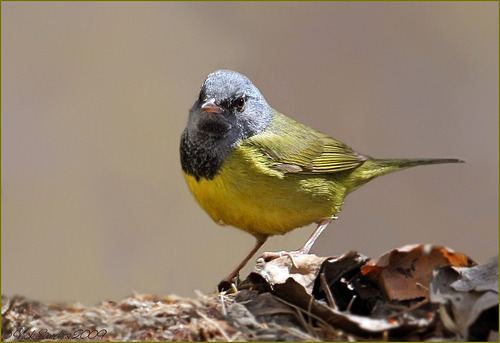

In [6]:
print('train length =', len(train))
example = vars(sample(train, 1)[0])
print(example)
display(Image.open(example['_impath']))

In [7]:
#
dataset  = [
    {
        'id'       : f'id:{i};modelstr:{modelstr};split:{sname}',
        'img_fpath': d.impath,
        'answer'   : d.classname,
        'split'    : sname,
        'modelstr' : modelstr
    }
    for sname, sdata in [('train', train), ('test', test)]
    for i, d in enumerate(sdata)
]
print(len(dataset))

11787

In [8]:
#
if is_peft_model:
    config = PeftConfig.from_pretrained(modelstr)
    processor = AutoProcessor.from_pretrained(
        config.base_model_name_or_path, 
        trust_remote_code=True
    )
    #
    model = AutoModelForImageTextToText.from_pretrained(
        config.base_model_name_or_path,
        torch_dtype = torch.bfloat16,
        device_map  = device_map,
    )
    model.generation_config.pad_token_id = processor.tokenizer.pad_token_id
    model = PeftModel.from_pretrained(model, modelstr)
    # model.enable_peft_hotswap(target_rank=256)
    # model.load_adapter(modelstr, adapter_name='cub200')
else:
    # Load model & processor
    processor = AutoProcessor.from_pretrained(
        modelstr,
        trust_remote_code = True
    )
    model     = AutoModelForImageTextToText.from_pretrained(
        modelstr,
        # torch_dtype       = "bfloat16",
        torch_dtype       = "float16",
        device_map        = device_map,
        trust_remote_code = True
    )
    model.generation_config.pad_token_id = processor.tokenizer.pad_token_id

#
model.eval()

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): Qwen2_5_VLMLP(
            (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
            (act_fn): SiLUAc

In [9]:
def select_token(h, input_ids=None, attention_mask=None, token_selector='last'):
    if token_selector == "cls":
        return h[:, 0, :]
    if token_selector == "last":
        if attention_mask is not None:
            last = attention_mask.long().sum(dim=1) - 1
            return h[torch.arange(h.size(0), device=h.device), last, :]
        return h[:, -1, :]
    if isinstance(token_selector, int):
        return h[:, token_selector, :]
    raise ValueError("bad token_selector")

In [15]:
acts = {}

def save_act(name):
    def hook(module, inp, out):
        if isinstance(out, (tuple, list)):
            acts[name] = out[0]
        elif isinstance(out, (torch.Tensor)):
            acts[name] = out
        elif hasattr(out, 'last_hidden_state'):
            acts[name] = out.last_hidden_state
        else:
            print(out)
            raise Exception()
        # acts[name] = out[0] if isinstance(out, (tuple, list)) else out
    return hook

In [11]:
from collections import OrderedDict
from typing import Dict, Callable
import torch

# usually you do:
# target_module = dict(model.named_modules())[target_name]
# handle        = target_module.register_forward_hook(save_act(target_name))
# but this link:
# https://discuss.pytorch.org/t/how-do-i-remove-forward-hooks-on-a-module-without-the-hook-handles/140393/2
# showed you can just set the OrderedDict to empty
def remove_all_forward_hooks(model: torch.nn.Module) -> None:
    acts = {}
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_forward_hooks"):
                child._forward_hooks: Dict[int, Callable] = OrderedDict()
            remove_all_forward_hooks(child)

In [17]:
remove_all_forward_hooks(model)

In [18]:
for target_name in module_map.values():

    #
    target_module = dict(model.named_modules())[target_name]
    target_module.register_forward_hook(save_act(target_name))

In [19]:
for example in track_progress_v1(shuffle_list(dataset)):

    #
    if example['id'] in cache:
        continue 

    #
    img_fpath = example['img_fpath']
    image     = Image.open(img_fpath)
    templated_conversation = processor.apply_chat_template(
        [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "What species of bird is in this image?"},
                ],
            },
        ],
        add_generation_prompt  = True,
        tokenize               = False
    )
    inputs = processor(
        images         = [image],
        text           = templated_conversation,
        return_tensors = "pt",
        return_dict    = True,
        padding        = True,
        padding_side   = 'left',
    )
    inputs = inputs.to(model.device)

    #
    with torch.no_grad():
        _ = model(**inputs, return_dict=True)

    #
    result              = {
        k: acts[v].cpu()
        for k,v in module_map.items()
    }
    result['row']       = example 
    result['input_ids'] = inputs['input_ids'].cpu().numpy()

    #
    # cache[example['id']] = result
    print(example)
    print({k:v.shape for k,v in acts.items()})
    print(result)
    break

{
    'id': 'id:5977;modelstr:Qwen/Qwen2.5-VL-7B-Instruct;split:train',
    'img_fpath': 
'/scratch3/workspace/lclawrence_umass_edu-storage_a/cub200_gtaclip/CUB_200_2011/images_extracted/Least_Flycatcher_0
080_30457.jpg',
    'answer': 'Least Flycatcher',
    'split': 'train',
    'modelstr': 'Qwen/Qwen2.5-VL-7B-Instruct'
}

{
    'model.visual.blocks.31': torch.Size([864, 1280]),
    'model.visual': torch.Size([216, 3584]),
    'model.language_model': torch.Size([1, 246, 3584])
}

{
    'vision_encoder': tensor([[-2.6465e-01,  2.4824e+00, -1.7637e+00,  ..., -8.7891e-03,
         -6.6641e+00, -5.9141e+00],
        [-8.0664e-01, -3.5762e+00, -3.1641e+00,  ..., -4.4531e+00,
         -9.7734e+00, -3.8887e+00],
        [-1.3711e+00,  1.1543e+00, -1.3271e+00,  ..., -2.2402e+00,
         -6.5430e+00, -3.1387e+00],
        ...,
        [-1.2148e+00,  7.7344e+00,  7.7930e-01,  ..., -5.0156e+00,
         -2.8164e+00, -3.4707e+00],
        [-1.3535e+00,  4.5273e+00, -1.4297e+00,  ..., -7.9453e+00,
         -2.8457e+00, -1.1898e+01],
        [-5.4609e+00,  8.1094e+00,  5.3418e-01,  ..., -6.5625e+00,
         -3.4727e+00,  1.4727e+00]], dtype=torch.float16),
    'connector': tensor([[ 1.0381e+00,  3.1055e-01,  1.1438e-01,  ..., -7.8516e-01,
         -9.7351e-02, -1.7900e+00],
        [-4.1562e+00,  6.5771e-01, -1.4287e+00,  ...,  1.4877e-03,
         -1.4160e+00, -1.6191e+00],
        [-1.6089e-01,  9.6289e-01, -1.6089e-01,  ...,  2.4487e-01,
          4.9976e-01, -4.1992e-02],
        ...,
        [-5.8301e-01, -9.3384e-02,  4.5197e-02,  ..., -2.4866e-01,
         -6.1371e-02,  2.9102e-01],
        [-9.6207e-03, -1.7542e-01,  3.0859e-01,  ..., -5.8887e-01,
          3.6072e-02, -1.2433e-01],
        [-4.9707e-01,  1.2500e-01,  7.1289e-01,  ...,  4.2578e-01,
         -8.2227e-01, -2.8931e-01]], dtype=torch.float16),
    'llm': tensor([[[ 0.4009,  0.7559, -0.9614,  ..., -6.4180, -1.0176, -1.3652],
         [-0.2111,  0.8594,  0.7661,  ..., -3.0547, -3.2871, -0.7734],
         [ 3.0273,  5.2734,  2.7578,  ...,  3.1250,  2.0859,  4.2891],
         ...,
         [ 4.1250, -1.1045, -0.8203,  ..., -4.9570, -3.2246,  0.7168],
         [ 3.3242,  0.4944,  3.7500,  ...,  0.7974,  7.3281,  2.9062],
         [-0.3242,  5.1367,  5.5742,  ...,  2.8652,  6.3477,  3.1230]]],
       dtype=torch.float16),
    'row': {
        'id': 'id:5977;modelstr:Qwen/Qwen2.5-VL-7B-Instruct;split:train',
        'img_fpath': 
'/scratch3/workspace/lclawrence_umass_edu-storage_a/cub200_gtaclip/CUB_200_2011/images_extracted/Least_Flycatcher_0
080_30457.jpg',
        'answer': 'Least Flycatcher',
        'split': 'train',
        'modelstr': 'Qwen/Qwen2.5-VL-7B-Instruct'
    },
    'input_ids': array([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,
            13, 151645,    198, 151644,    872,    198, 151652, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655